# ARIMA


In [7]:
# Load the saved model and make predictions on the test data    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.serialize import model_to_json, model_from_json
from prophet.utilities import regressor_coefficients
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [8]:
# Import the data 
def load_and_prepare_data(file_path):
    """
    Load energy prices data from a CSV file, ensure chronological order, and convert 'Date' to datetime.
    """
    df = pd.read_csv(file_path)
    df.sort_values('Date', inplace=True)
    # Convert 'date' column to datetime
    df['Date'] = pd.to_datetime(df['Date'])
    #df.set_index('Date', inplace=True)
    df = pd.DataFrame(df)
    return df

In [32]:
# Define the future covariates columns from your dataframe
future_covariates_columns = ['Solar_radiation (W/m2)', 'Wind_speed (m/s)', 'Temperature (°C)', 
                             'Biomass (GWh)', 'Hard_coal (GWh)', 'Hydro (GWh)', 'Lignite (GWh)', 
                             'Natural_gas (GWh)', 'Other (GWh)', 'Pumped_storage_generation (GWh)', 
                             'Solar_energy (GWh)', 'Wind_offshore (GWh)', 'Wind_onshore (GWh)', 
                             'Net_total_export_import (GWh)', 'BEV_vehicles', 'Oil_price (EUR)', 
                             'TTF_gas_price (€/MWh)', 'Nuclear_energy (GWh)']

future_covariates_columns_2 = ['Solar_radiation (W/m2)', 'Wind_speed (m/s)',
       'Temperature (°C)', 'Biomass (GWh)', 'Hard_coal (GWh)', 'Hydro (GWh)',
       'Lignite (GWh)', 'Natural_gas (GWh)', 'Other (GWh)',
       'Pumped_storage_generation (GWh)', 'Solar_energy (GWh)',
       'Wind_offshore (GWh)', 'Wind_onshore (GWh)',
       'Net_total_export_import (GWh)', 'BEV_vehicles', 'Oil_price (EUR)',
       'TTF_gas_price (€/MWh)', 'Nuclear_energy (GWh)', 'Lag_1_day',
       'Lag_2_days', 'Lag_3_days', 'Lag_4_days', 'Lag_5_days', 'Lag_6_days',
       'Lag_7_days', 'Day_of_week', 'Month', 'Rolling_mean_7']

In [10]:
# Load in the train and test data
train_df = load_and_prepare_data('../../data/Final_data/train_df.csv')
test_df = load_and_prepare_data('../../data/Final_data/test_df.csv')

# Concatenate the train and test data
df = pd.concat([train_df, test_df])
df['Date'] = pd.to_datetime(df['Date'])

df

,Date,Day_ahead_price (€/MWh),Solar_radiation (W/m2),Wind_speed (m/s),Temperature (°C),Biomass (GWh),Hard_coal (GWh),Hydro (GWh),Lignite (GWh),Natural_gas (GWh),...,Lag_1_day,Lag_2_days,Lag_3_days,Lag_4_days,Lag_5_days,Lag_6_days,Lag_7_days,Day_of_week,Month,Rolling_mean_7
0,2012-01-08,26.83,17.54,5.21,3.74,98.605,189.718,48.467,354.178,256.892,...,32.58,36.26,20.35,32.16,35.03,33.82,18.19,6,1,31.00
1,2012-01-09,47.91,13.04,4.24,3.80,98.605,344.154,49.054,382.756,282.438,...,26.83,32.58,36.26,20.35,32.16,35.03,33.82,0,1,33.02
2,2012-01-10,45.77,28.71,4.30,4.81,98.605,360.126,51.143,334.267,267.311,...,47.91,26.83,32.58,36.26,20.35,32.16,35.03,1,1,34.55
3,2012-01-11,47.83,21.58,4.08,5.14,98.605,360.330,50.693,385.000,277.343,...,45.77,47.91,26.83,32.58,36.26,20.35,32.16,2,1,36.79
4,2012-01-12,43.10,25.12,6.77,4.98,98.605,306.521,50.732,332.985,266.820,...,47.83,45.77,47.91,26.83,32.58,36.26,20.35,3,1,40.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
754,2024-07-24,66.61,225.04,3.47,17.54,110.007,43.469,85.857,199.246,194.291,...,79.62,88.75,58.45,59.32,86.47,90.75,76.79,2,7,75.71
755,2024-07-25,78.34,272.71,2.12,17.85,110.410,50.676,82.632,195.983,209.610,...,66.61,79.62,88.75,58.45,59.32,86.47,90.75,3,7,73.94
756,2024-07-26,93.04,172.33,2.60,19.09,110.852,42.333,79.531,205.273,205.773,...,78.34,66.61,79.62,88.75,58.45,59.32,86.47,4,7,74.88
757,2024-07-27,80.74,176.67,2.05,19.63,110.479,33.307,74.958,184.012,216.412,...,93.04,78.34,66.61,79.62,88.75,58.45,59.32,5,7,77.94


In [11]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['Day_ahead_price (€/MWh)'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])


ADF Statistic: -3.7192929636344276
p-value: 0.003849821614701235


In [12]:
from statsmodels.tsa.stattools import kpss

kpss_stat, p_value, lags, crit_values = kpss(df['Day_ahead_price (€/MWh)'])
print('KPSS Statistic:', kpss_stat)
print('p-value:', p_value)


KPSS Statistic: 3.57507807732268
p-value: 0.01


/var/folders/8w/b_0gc01d70g6h4k62sb7ytyw0000gn/T/ipykernel_8212/2126859154.py:3: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




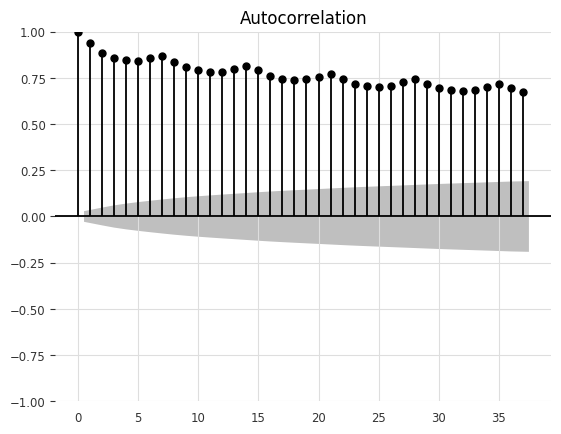

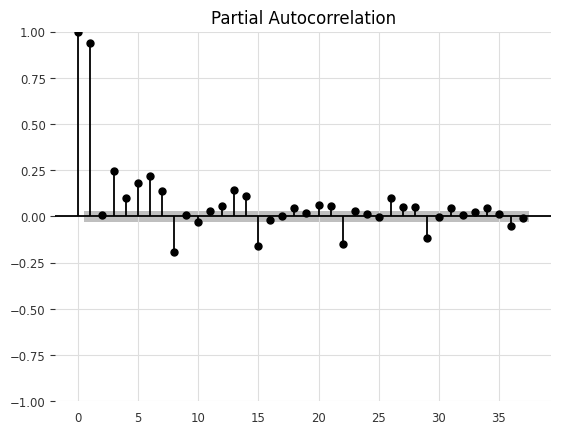

In [13]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Assuming 'df' contains your time series data
plot_acf(df['Day_ahead_price (€/MWh)'])
plt.show()

plot_pacf(df['Day_ahead_price (€/MWh)'])
plt.show()


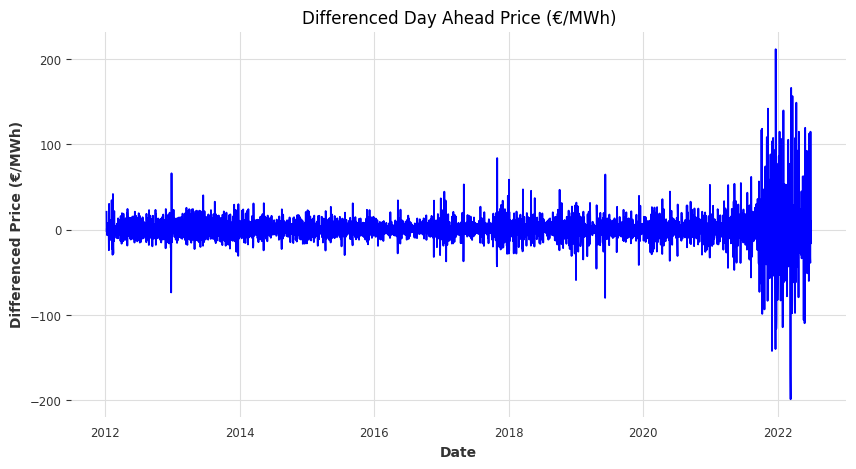

ADF Statistic: -15.429463005454169
p-value: 2.961677446374705e-28
KPSS Statistic: 0.41163254453847936
p-value: 0.07214114459548304


In [14]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller, kpss
import matplotlib.pyplot as plt

def load_and_prepare_data(file_path):
    df = pd.read_csv(file_path)
    df.sort_values('Date', inplace=True)
    df['Date'] = pd.to_datetime(df['Date'])
    return df

# Load data
file_path = '../../data/Final_data/train_df.csv'  # Change the path as necessary
df = load_and_prepare_data(file_path)

# Perform first-order differencing on the target variable
df['Day_ahead_price_diff'] = df['Day_ahead_price (€/MWh)'].diff().dropna()

# Plot the differenced series
plt.figure(figsize=(10, 5))
plt.plot(df['Date'], df['Day_ahead_price_diff'], color='blue')
plt.title('Differenced Day Ahead Price (€/MWh)')
plt.xlabel('Date')
plt.ylabel('Differenced Price (€/MWh)')
plt.show()

# Perform ADF test on differenced data
adf_result = adfuller(df['Day_ahead_price_diff'].dropna())
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])

# Perform KPSS test on differenced data
kpss_stat, p_value, lags, crit_values = kpss(df['Day_ahead_price_diff'].dropna())
print('KPSS Statistic:', kpss_stat)
print('p-value:', p_value)


## Autoarima

In [35]:
from darts.models import AutoARIMA
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
import pandas as pd
import plotly.graph_objects as go
from darts.metrics import mape, mae, rmse, mse

# Load and prepare data
def load_and_prepare_data(file_path):
    df = pd.read_csv(file_path)
    df.sort_values('Date', inplace=True)
    df['Date'] = pd.to_datetime(df['Date'])
    return df

# Load target and covariate data
train_df = load_and_prepare_data('../../data/Final_data/train_df.csv')
test_df = load_and_prepare_data('../../data/Final_data/test_df.csv')

# Create target TimeSeries
series_train = TimeSeries.from_dataframe(train_df, 'Date', 'Day_ahead_price (€/MWh)').astype('float32')
series_test = TimeSeries.from_dataframe(test_df, 'Date', 'Day_ahead_price (€/MWh)').astype('float32')

# Convert covariates to TimeSeries
covariates_train = TimeSeries.from_dataframe(train_df, 'Date', future_covariates_columns_2).astype('float32')
covariates_test = TimeSeries.from_dataframe(test_df, 'Date', future_covariates_columns_2).astype('float32')

# Scale both target and covariates
scaler_target = Scaler()
scaler_covariates = Scaler()

series_train_scaled = scaler_target.fit_transform(series_train)
covariates_train_scaled = scaler_covariates.fit_transform(covariates_train)
series_test_scaled = scaler_target.transform(series_test)
covariates_test_scaled = scaler_covariates.transform(covariates_test)

# Initialize AutoARIMA model
model = AutoARIMA(seasonal=True, m=7, max_p=5, max_d=2, max_q=5, information_criterion='aic')

# Fit the model with covariates
model.fit(series_train_scaled, future_covariates=covariates_train_scaled)

# Forecast with covariates
n = len(series_test_scaled)
forecast_scaled = model.predict(n=n, future_covariates=covariates_test_scaled)

# Inverse transform the forecast
forecast = scaler_target.inverse_transform(forecast_scaled)
test_series = scaler_target.inverse_transform(series_test_scaled)

# Plot the actual vs forecasted data
fig = go.Figure()

# Add actual test data
fig.add_trace(go.Scatter(x=test_series.time_index,
                         y=test_series.values().squeeze(),
                         mode='lines', name='Actual', line=dict(color='blue')))

# Add forecasted data
fig.add_trace(go.Scatter(x=forecast.time_index,
                         y=forecast.values().squeeze(),
                         mode='lines', name='Forecast', line=dict(color='red')))

# Update layout
fig.update_layout(title='AutoARIMA Model - Forecast with Covariates',
                  xaxis_title='Date', yaxis_title='Day Ahead Price (€/MWh)',
                  legend=dict(x=1, y=1, xanchor='right', yanchor='top', bordercolor='black', borderwidth=1),
                  template='plotly_white')

# Save the plot as a PNG image
plot_path = "autoarima_forecast_plot.png"
fig.write_image(plot_path)
print(f"Forecast plot saved at: {plot_path}")

# Calculate error metrics
mape_value = mape(test_series, forecast)
mae_value = mae(test_series, forecast)
rmse_value = rmse(test_series, forecast)
mse_value = mse(test_series, forecast)

# Print error metrics
print('Error Metrics on Test Set:')
print(f'Mean Absolute Percentage Error (MAPE): {mape_value:.2f}%')
print(f'Mean Absolute Error (MAE): {mae_value:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse_value:.2f}')
print(f'Mean Squared Error (MSE): {mse_value:.2f}')

# Save error metrics to CSV
metrics_path = "autoarima_error_metrics.csv"
metrics_df = pd.DataFrame({
    "Metric": ["MAPE", "MAE", "RMSE", "MSE"],
    "Value": [mape_value, mae_value, rmse_value, mse_value]
})
metrics_df.to_csv(metrics_path, index=False)
print(f"Error metrics saved at: {metrics_path}")


Forecast plot saved at: autoarima_forecast_plot.png
Error Metrics on Test Set:
Mean Absolute Percentage Error (MAPE): 51.47%
Mean Absolute Error (MAE): 17.43
Root Mean Squared Error (RMSE): 25.30
Mean Squared Error (MSE): 639.94
Error metrics saved at: autoarima_error_metrics.csv
